### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

# Estilos de Seaborn
sns.set()
sns.set_palette(palette='colorblind')

In [5]:
def autolabel_pct(pct):
    return "{:.1f}%".format(pct)

def autolabel_height(grafico, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for bar in grafico.patches:
        height = bar.get_height()
        grafico.text(bar.get_x() + bar.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


### Carga de datos

In [3]:
columnas_cargar = [ "created","application_id", "ref_type", "attributed", "implicit",
                   "device_brand", "event_uuid", "kind", "wifi", 'ref_hash']

installs = pd.read_csv("../../../data/installs.csv", usecols=columnas_cargar, parse_dates=["created"])

installs.ref_type = installs.ref_type.astype('category')

columnas_cargar = ['event_uuid', 'attributed', 'kind']

eventos = pd.read_csv('../../../data/events.csv', usecols=columnas_cargar)

eventos= eventos.rename(columns = {"attributed": "attributed_evento", 'kind': 'kind_evento'})

columnas_cargar = ['created', 'touchX', 'touchY', 'ref_hash']

clicks = pd.read_csv('../../../data/clicks.csv', usecols = columnas_cargar, parse_dates=["created"])



In [83]:
installs.dtypes

created           datetime64[ns]
application_id             int64
ref_type                category
ref_hash                   int64
attributed                  bool
implicit                    bool
device_brand             float64
event_uuid                object
kind                      object
wifi                      object
dtype: object

# Preguntas:

## Cuántos installs hubieron? 

In [84]:
installs.ref_hash.count()

3412

## Cuántos fueron atribuidos a Jampp?

In [85]:
installs[installs["attributed"]].ref_hash.count()

0

In [86]:
installs[installs["implicit"]].ref_hash.count()

865

# Análisis de Installs en el tiempo

### Cómo evolucionaron los installs en el mes?

Text(0.5, 0, 'Día')

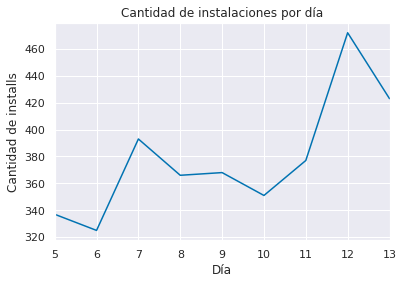

In [87]:
# add a column hours and days
installs["hours"] = installs['created'].dt.hour
installs["days"] = installs['created'].dt.day

installs_por_dia = installs.groupby(installs['days']).ref_hash.agg("count").rename(columns ={"ref_hash":"Cantidad de Installs"})
    
installs_por_dia.plot(kind="line")
plt.title("Cantidad de instalaciones por día")
plt.ylabel("Cantidad de installs")
plt.xlabel("Día")


In [88]:
installs_por_dia.max()

472

Text(0.5, 0, 'Día')

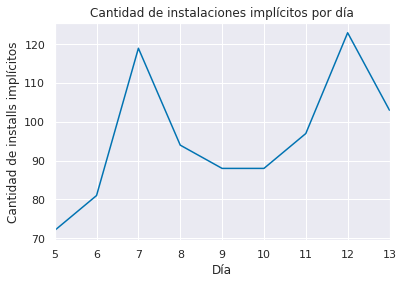

In [89]:
install_implicitos = installs[installs["implicit"]]

installs_por_dia = install_implicitos.groupby(installs['days']).ref_hash.agg("count").rename(columns ={"ref_hash":"Cantidad de Installs"})
    
installs_por_dia.plot(kind="line")
plt.title("Cantidad de instalaciones implícitos por día")
plt.ylabel("Cantidad de installs implícitos")
plt.xlabel("Día")


In [90]:
(installs[installs['created'].dt.day == 12])['created'].dt.day_name().iloc[0]

'Tuesday'

### Cómo evolucionaron los installs según la hora del día?

Text(0.5, 0, 'Hora')

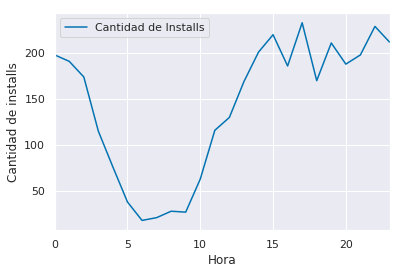

In [91]:
installs_por_hora = installs.groupby(installs['hours']).agg({"ref_hash":"count"}).rename(columns ={"ref_hash":"Cantidad de Installs"})
    
installs_por_hora.plot(kind="line")
plt.ylabel("Cantidad de installs")
plt.xlabel("Hora")

Text(0.5, 0, 'Hora')

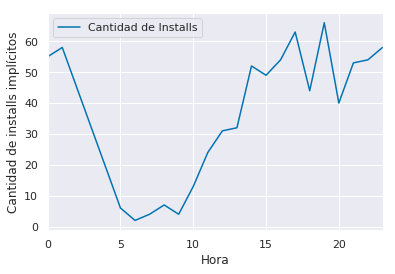

In [114]:
install_implicitos_hora = installs[installs["implicit"]]
install_implicitos_hora = install_implicitos_hora.groupby(installs['hours']).agg({"ref_hash" : "count"}).rename(columns ={"ref_hash":"Cantidad de Installs"})
     
install_implicitos_hora.plot(kind="line")
plt.ylabel("Cantidad de installs implícitos")
plt.xlabel("Hora")

Text(111.5, 0.5, 'Hora del día')

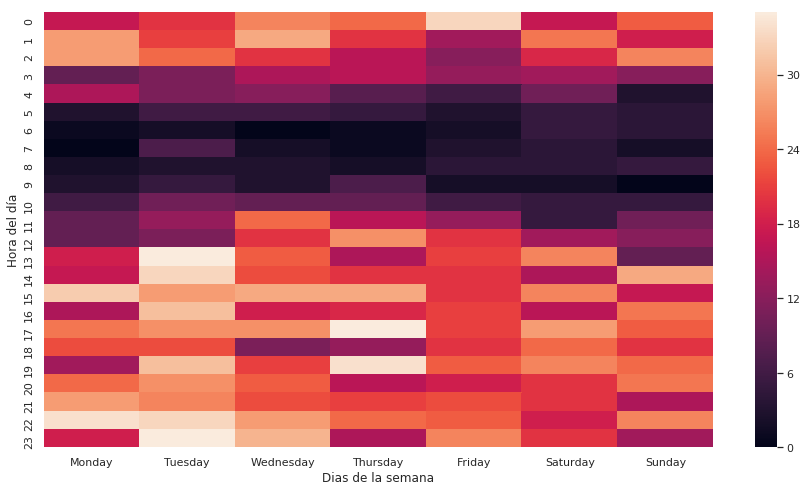

In [93]:
installs["day_of_week"] = installs["created"].dt.day_name()
install_count = installs[(installs["created"] >= "03-07-2019")]\
                .groupby( [pd.Grouper(key="created",freq="h"),"day_of_week" ])["ref_hash"].count().reset_index()
intalls_por_dia_hora = install_count.pivot("created","day_of_week","ref_hash").reset_index()
intalls_por_dia_hora["created"] = intalls_por_dia_hora["created"].dt.hour  
intalls_por_dia_hora = intalls_por_dia_hora.groupby("created").agg("sum")
column_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
intalls_por_dia_hora = intalls_por_dia_hora.reindex(column_order, axis=1)

fig,ax = plt.subplots(figsize = (15,8))
sns.heatmap(intalls_por_dia_hora)
ax.set_xlabel("Dias de la semana")
ax.set_ylabel("Hora del día")


# Análisis de Installs en el por marcas

### Cuáles marcas tuvieron más installs?

In [94]:
installs_por_marca = installs.groupby(['device_brand', 'ref_type']).agg({"ref_hash" : "count"}) 
otros = installs_por_marca[installs_por_marca['ref_hash'] < 30]
installs_por_marca = installs_por_marca[installs_por_marca['ref_hash'] >= 30].reset_index()


In [95]:
adjuntar = pd.DataFrame([['Other', otros.ref_hash.sum()]])
adjuntar.columns = ['device_brand','ref_hash']

installs_por_marca =installs_por_marca.append(adjuntar)
installs_por_marca = installs_por_marca.rename(columns = {"ref_hash": "cantidad_de_instalaciones"})

/home/matiasleal/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Text(0.5, 0, 'Marca')

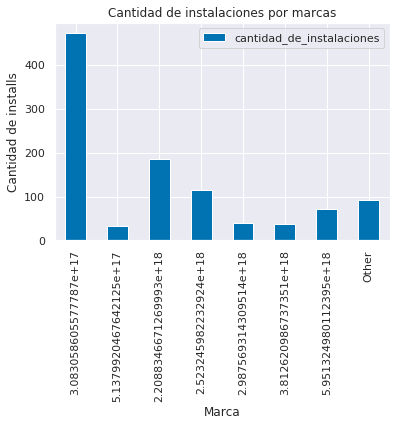

In [96]:
installs_por_marca.plot(x='device_brand', y='cantidad_de_instalaciones',kind="bar")
plt.title("Cantidad de instalaciones por marcas")
plt.ylabel("Cantidad de installs")
plt.xlabel("Marca")


In [97]:
installs_por_marca.sort_values('cantidad_de_instalaciones', ascending=False).head(5)

,device_brand,cantidad_de_instalaciones,ref_type
0,3.08306e+17,472,1891515180541284343
2,2.20883e+18,185,1891515180541284343
3,2.52325e+18,116,1891515180541284343
0,Other,91,NaN
6,5.95132e+18,72,1494519392962156891


Text(0.5, 0, 'OS')

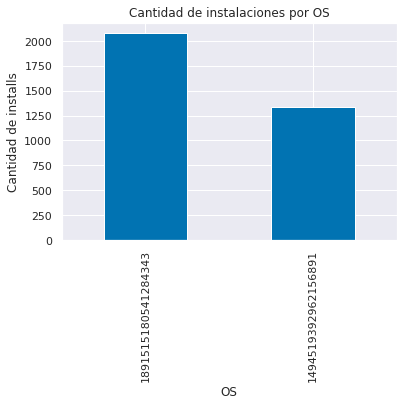

In [98]:
installs_por_os = installs['ref_type'].value_counts()
installs_por_os.plot(x='ref_type', y='ref_hash',kind="bar")
plt.title("Cantidad de instalaciones por OS")
plt.ylabel("Cantidad de installs")
plt.xlabel("OS")


In [99]:
installs['ref_type'].value_counts(normalize=True)

1891515180541284343    0.609613
1494519392962156891    0.390387
Name: ref_type, dtype: float64

# Análisis de Installs y WIFI


### Installs con WIFI ?

Text(0.5, 0.98, 'Conexión a red de Wifi')

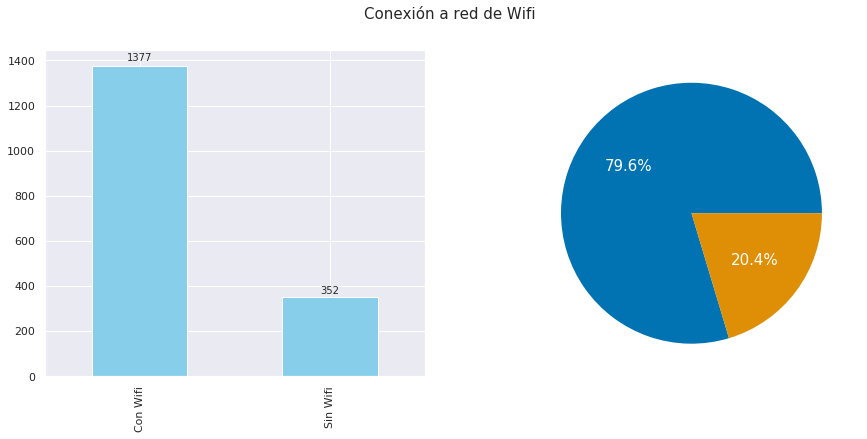

In [7]:
fig, ejes = plt.subplots(nrows = 1,ncols = 2, figsize = (15,6), )
ax1 = ejes[0]
ax2 = ejes[1]

datos = installs['wifi'].value_counts()
labels = ["Con Wifi", "Sin Wifi"]

graf_barras = datos.plot(kind = "bar",color = "SkyBlue",ax=ax1)
ax1.set_xticklabels(labels)
ax1.set_ylabel = "Cantidad de instalaciones"
ax1.set_xlabel = "WIFI"
autolabel_height(graf_barras)

porc,text,autotext = ax2.pie(datos, autopct = autolabel_pct)

for p in porc:
    p.set_linewidth(0)
    p.set_edgecolor("Orange")

for t in autotext:
    t.set_fontsize(15)
    t.set_color("white")
    

fig.suptitle("Conexión a red de Wifi",fontsize = 15)

In [101]:
installs['wifi'].value_counts(normalize=True)

True     0.796414
False    0.203586
Name: wifi, dtype: float64

# Eventos y Installs

### Eventos anteriores al install

In [102]:
install_evento = pd.merge(installs.dropna(subset=['event_uuid']), eventos , how='inner', on='event_uuid')

In [103]:
install_evento_ant = install_evento.groupby(install_evento['kind_evento']).agg({"ref_hash" : "count"}) 

otros = install_evento_ant[install_evento_ant['ref_hash'] < 10]
install_evento_ant = install_evento_ant[install_evento_ant['ref_hash'] >= 10].reset_index()


In [104]:
adjuntar = pd.DataFrame([['Other', otros.ref_hash.sum()]])
adjuntar.columns = ['kind_evento','ref_hash']

install_evento_ant =install_evento_ant.append(adjuntar)
install_evento_ant = install_evento_ant.rename(columns = {"ref_hash": "cantidad_de_instalaciones_por_evento"})

Text(0.5, 0, 'Evento')

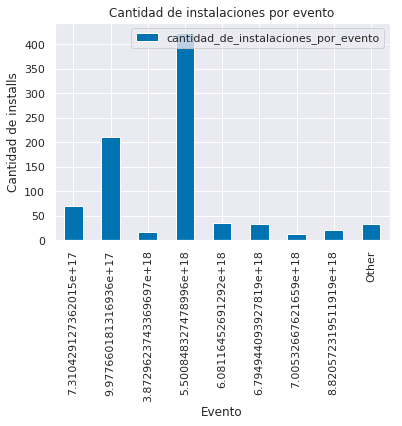

In [105]:
install_evento_ant.plot(x='kind_evento', y='cantidad_de_instalaciones_por_evento',kind="bar")
plt.title("Cantidad de instalaciones por evento")
plt.ylabel("Cantidad de installs")
plt.xlabel("Evento")


# Aplicaciones e Installs
## Aplicaciones con más installs

In [106]:
installs_implicitos = installs[installs["implicit"]]

installs_implicitos = installs_implicitos.groupby(installs['application_id']).agg({"ref_hash" : "count"}).reset_index()

otros = installs_implicitos[installs_implicitos['ref_hash'] < 20]
installs_implicitos = installs_implicitos[installs_implicitos['ref_hash'] >= 20].reset_index()



In [107]:
adjuntar = pd.DataFrame([['Other', otros.ref_hash.sum()]])
adjuntar.columns = ['application_id','ref_hash']

installs_implicitos =installs_implicitos.append(adjuntar)
installs_implicitos = installs_implicitos.rename(columns = {"ref_hash": "cantidad_de_instalaciones_por_aplicacion"})


/home/matiasleal/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Text(0.5, 0, 'Aplicación')

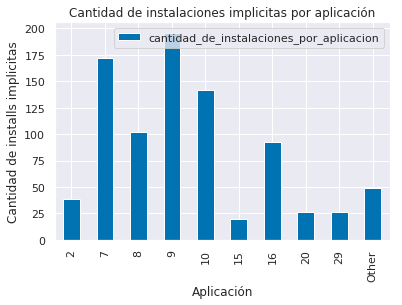

In [108]:
installs_implicitos.plot(x='application_id', y='cantidad_de_instalaciones_por_aplicacion',kind="bar")
plt.title("Cantidad de instalaciones implicitas por aplicación")
plt.ylabel("Cantidad de installs implicitas")
plt.xlabel("Aplicación")


Text(0.5, 0, 'Aplicación')

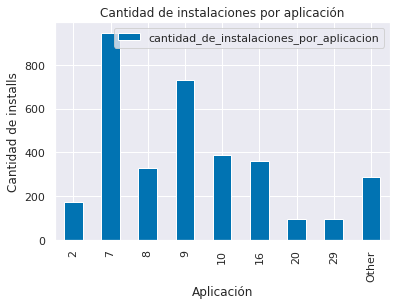

In [109]:
aplicaciones_con_mas_installs = installs.groupby(installs['application_id']).agg({"ref_hash" : "count"}).reset_index()

otros = aplicaciones_con_mas_installs[aplicaciones_con_mas_installs['ref_hash'] < 50]
aplicaciones_con_mas_installs = aplicaciones_con_mas_installs[aplicaciones_con_mas_installs['ref_hash'] >= 50].reset_index()

adjuntar = pd.DataFrame([['Other', otros.ref_hash.sum()]])
adjuntar.columns = ['application_id','ref_hash']

aplicaciones_con_mas_installs =aplicaciones_con_mas_installs.append(adjuntar)
aplicaciones_con_mas_installs = aplicaciones_con_mas_installs.rename(columns = {"ref_hash": "cantidad_de_instalaciones_por_aplicacion"})

aplicaciones_con_mas_installs.plot(x='application_id', y='cantidad_de_instalaciones_por_aplicacion',kind="bar")
plt.title("Cantidad de instalaciones por aplicación")
plt.ylabel("Cantidad de installs")
plt.xlabel("Aplicación")


# Clicks es installs

## Clicks correspondientes a installs

In [110]:
install_click = pd.merge(installs.dropna(subset=['ref_hash']), clicks , how='inner', on='ref_hash')
install_click = install_click.rename(columns = {'created_y': 'created_click'})
install_click['created_click'] = install_click['created_click'].dt.tz_convert(None)
install_click = install_click.rename(columns = {'created_x': 'created_install'})
install_click[install_click['created_install'].dt.date == (install_click['created_click'].dt.date) ]



,created_install,application_id,ref_type,ref_hash,attributed,implicit,device_brand,event_uuid,kind,wifi,hours,days,day_of_week,created_click,touchX,touchY
10,2019-03-10 08:30:15.346,7,1891515180541284343,2369915544093215150,False,False,NaN,NaN,NaN,NaN,8,10,Sunday,2019-03-10 10:29:19.742,0.308,0.879
